# DA5401 A6: Imputation via Regression for Missing Data

**Objective:** This notebook tackles the common problem of missing data in a credit risk assessment dataset. We will implement and compare four different strategies for handling missing values:
1.  **Median Imputation** (Simple Baseline)
2.  **Linear Regression Imputation**
3.  **Non-Linear Regression Imputation** (using K-Nearest Neighbors)
4.  **Listwise Deletion** (Dropping rows)

The effectiveness of each strategy will be evaluated by training a Logistic Regression classifier on the cleaned datasets and comparing their predictive performance.

## 1. Setup and Environment Configuration

First, let's import all the necessary libraries for data manipulation, machine learning, and visualization.

In [24]:
# --- Data Manipulation ---
import pandas as pd
import numpy as np

# --- Machine Learning ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, f1_score
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
RANDOM_STATE = 42

## Part A: Data Preprocessing and Imputation

In this section, we'll load the dataset, artificially introduce missing values to simulate a real-world scenario, and then apply our three different imputation techniques.

### Step 1.1: Load and Prepare Data

We'll start by loading the "UCI Credit Card Default Clients Dataset". The original dataset is clean, so as per the assignment instructions, we will artificially introduce **5% Missing At Random (MAR)** values into three numerical columns: `AGE`, `BILL_AMT1`, and `BILL_AMT2`.

In [25]:
file_path = '/content/UCI_Credit_Card.csv'
try:
    df_original = pd.read_csv(file_path)
except FileNotFoundError:
    print("File not found. Please make sure 'UCI_Credit_Card.csv' is uploaded to your Colab session.")
    df_original = pd.DataFrame()

if not df_original.empty:
    # --- Data Cleaning and Preparation ---
    df_original.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)
    df_original.drop('ID', axis=1, inplace=True)

    print("Original Dataset Info:")
    df_original.info()
    print("\nOriginal Dataset Head:")
    print(df_original.head())

    # --- Introduce Missing Values ---
    df_missing = df_original.copy()
    cols_to_nan = ['AGE', 'BILL_AMT1', 'BILL_AMT2']
    percentage_to_nan = 0.05 # 5%

    for col in cols_to_nan:
        n_missing = int(len(df_missing) * percentage_to_nan)
        # Get random indices to set to NaN
        missing_indices = np.random.choice(df_missing.index, n_missing, replace=False)
        df_missing.loc[missing_indices, col] = np.nan

    print("\n--- Dataset with Missing Values ---")
    print("Number of missing values introduced:")
    print(df_missing[cols_to_nan].isnull().sum())

Original Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-nu

### Step 1.2: Imputation Strategy 1: Simple Imputation (Median)

Our first approach, **Dataset A**, will be our baseline. We'll fill the missing values in each column with that column's **median**.

In [26]:
# Create a copy for Dataset A
df_A = df_missing.copy()

# Impute missing values with the median
for col in cols_to_nan:
    median_val = df_A[col].median()
    df_A[col].fillna(median_val, inplace=True)

print("--- Dataset A (Median Imputation) ---")
print("Missing values after median imputation:")
print(df_A[cols_to_nan].isnull().sum())

--- Dataset A (Median Imputation) ---
Missing values after median imputation:
AGE          0
BILL_AMT1    0
BILL_AMT2    0
dtype: int64


#### Why is the median often preferred over the mean for imputation?

The **median** is generally preferred over the **mean** for imputation because it is **robust to outliers**. The mean is sensitive to extreme values, and if the data is skewed, the mean can be pulled towards the tail, providing a biased estimate for the missing data. The median, representing the 50th percentile, is not affected by these extreme values, making it a more stable and representative measure of central tendency for skewed distributions, which are common in real-world data like financial transactions (`BILL_AMT`) or age.

### Step 1.3: Imputation Strategy 2: Regression Imputation (Linear)

For our second approach, **Dataset B**, we will use a more sophisticated technique. We will impute the `AGE` column using a **Linear Regression** model trained on other features. For the other two columns with missing data (`BILL_AMT1` and `BILL_AMT2`), we will fall back to median imputation to create a fully clean dataset.

In [27]:
# Create a copy for Dataset B
df_B = df_missing.copy()

# --- Linear Regression Imputation for 'AGE' ---

# 1. Define features (X) and target (y) for the regression model
impute_col = 'AGE'
# Use all columns except the target ('DEFAULT') and the columns we need to impute
features = [col for col in df_B.columns if col not in ['DEFAULT'] + cols_to_nan]

# 2. Split data into training (no missing 'AGE') and prediction (missing 'AGE') sets
train_impute = df_B[df_B[impute_col].notnull()]
predict_impute = df_B[df_B[impute_col].isnull()]

X_train_impute = train_impute[features]
y_train_impute = train_impute[impute_col]
X_predict_impute = predict_impute[features]

# 3. Train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_impute, y_train_impute)

# 4. Predict the missing 'AGE' values
predicted_age = lin_reg.predict(X_predict_impute)

# 5. Fill in the missing values in Dataset B
df_B.loc[df_B[impute_col].isnull(), impute_col] = predicted_age

# --- Median Imputation for Other Columns ---
for col in ['BILL_AMT1', 'BILL_AMT2']:
    median_val = df_B[col].median()
    df_B[col].fillna(median_val, inplace=True)

print("--- Dataset B (Linear Regression Imputation) ---")
print("Missing values after imputation:")
print(df_B.isnull().sum().sum()) # Should be 0

--- Dataset B (Linear Regression Imputation) ---
Missing values after imputation:
0


#### What is the underlying assumption of regression imputation?

The core assumption behind regression imputation is that the data is **Missing At Random (MAR)**. This means that the probability of a value being missing in a column (e.g., `AGE`) depends only on other *observed* information in the dataset (e.g., `LIMIT_BAL`, `EDUCATION`, etc.), and not on the missing value itself. For our model, this assumes that a person's age can be reasonably predicted from their other financial and demographic data, and that there isn't some unobserved reason related to their *actual* age that caused the data to be missing.

### Step 1.4: Imputation Strategy 3: Regression Imputation (Non-Linear)

For our third approach, **Dataset C**, we will use a **K-Nearest Neighbors (KNN) Regressor** to impute the `AGE` column. KNN is a non-linear model that predicts a missing value based on the average value of its 'k' nearest neighbors in the feature space. This can capture more complex relationships than a simple linear model.

We'll also perform a quick hyperparameter tune to find the optimal number of neighbors (`k`) for the KNN model.

In [28]:
# Create a copy for Dataset C
df_C = df_missing.copy()

# --- KNN Regression Imputation for 'AGE' ---
# 1. Hyperparameter tuning for KNN Regressor to find the best 'k'
knn_imputer = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]} # Test a few values for k

grid_search_knn = GridSearchCV(knn_imputer, param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train_impute, y_train_impute)

best_k = grid_search_knn.best_params_['n_neighbors']
print(f"Optimal number of neighbors (k) for KNN Imputation: {best_k}")

# 2. Train the KNN model with the best 'k'
best_knn_imputer = KNeighborsRegressor(n_neighbors=best_k)
best_knn_imputer.fit(X_train_impute, y_train_impute)

# 3. Predict the missing 'AGE' values
predicted_age_knn = best_knn_imputer.predict(X_predict_impute)

# 4. Fill in the missing values in Dataset C
df_C.loc[df_C[impute_col].isnull(), impute_col] = predicted_age_knn

# --- Median Imputation for Other Columns ---
for col in ['BILL_AMT1', 'BILL_AMT2']:
    median_val = df_C[col].median()
    df_C[col].fillna(median_val, inplace=True)

print("\n--- Dataset C (KNN Regression Imputation) ---")
print("Missing values after imputation:")
print(df_C.isnull().sum().sum()) # Should be 0

Optimal number of neighbors (k) for KNN Imputation: 9

--- Dataset C (KNN Regression Imputation) ---
Missing values after imputation:
0


##  Part B: Model Training and Performance Assessment

Now that we have three clean datasets (A, B, C), we'll create a fourth by simply deleting rows with missing values (Listwise Deletion). Then, we will train and evaluate a Logistic Regression classifier on all four datasets.

### Step 2.1: Create Dataset D (Listwise Deletion)

**Dataset D** is created by dropping every row that contains at least one missing value.

In [29]:
# Create Dataset D by dropping all rows with any NaN values
df_D = df_missing.dropna()

print("--- Dataset D (Listwise Deletion) ---")
print(f"Shape of original dataset with missing values: {df_missing.shape}")
print(f"Shape of Dataset D after listwise deletion: {df_D.shape}")
print(f"Number of rows lost: {len(df_missing) - len(df_D)}")

--- Dataset D (Listwise Deletion) ---
Shape of original dataset with missing values: (30000, 24)
Shape of Dataset D after listwise deletion: (25726, 24)
Number of rows lost: 4274


### Step 2.2: Data Splitting, Scaling, and Classifier Setup

We will now prepare all four datasets for modeling. This involves:
1.  Separating features (X) from the target (y).
2.  Splitting each dataset into training and testing sets.
3.  Applying `StandardScaler` to standardize the features. **Crucially**, we fit the scaler *only* on the training data to prevent data leakage from the test set.

In [30]:
# Create a dictionary to hold our datasets
datasets = {
    "Median Imputation": df_A,
    "Linear Regression Imputation": df_B,
    "Non-Linear (KNN) Imputation": df_C,
    "Listwise Deletion": df_D
}

# Dictionary to store results
results = {}

# Process each dataset
for name, df in datasets.items():
    print(f"\n--- Processing: {name} ---")

    # 1. Define Features (X) and Target (y)
    X = df.drop('DEFAULT', axis=1)
    y = df['DEFAULT']

    # 2. Split Data into Training and Testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # 3. Standardize Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Store the processed data for the next step
    datasets[name] = (X_train_scaled, X_test_scaled, y_train, y_test)


--- Processing: Median Imputation ---

--- Processing: Linear Regression Imputation ---

--- Processing: Non-Linear (KNN) Imputation ---

--- Processing: Listwise Deletion ---


### Step 2.3: Model Training, Tuning, and Evaluation

We will now train a **Logistic Regression** classifier for each of the four preprocessed datasets. To find the optimal model, we'll use `GridSearchCV` to tune the regularization parameter `C`, which controls the trade-off between model complexity and fitting the data.

In [31]:
# --- Setup for Logistic Regression and Hyperparameter Tuning ---
log_reg = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000)

param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Dictionary to store the classification reports
classification_reports = {}

# --- Loop through each dataset to train and evaluate ---
for name, (X_train_scaled, X_test_scaled, y_train, y_test) in datasets.items():
    print(f"\n--- Training and Evaluating Model for: {name} ---")

    # Use GridSearchCV to find the best 'C'
    grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1')
    grid_search_lr.fit(X_train_scaled, y_train)

    print(f"Best parameter (C): {grid_search_lr.best_params_}")

    # Evaluate the best model on the test set
    best_model = grid_search_lr.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    # Generate and store the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports[name] = report

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


--- Training and Evaluating Model for: Median Imputation ---
Best parameter (C): {'C': 0.001}

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.68      0.25      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000


--- Training and Evaluating Model for: Linear Regression Imputation ---
Best parameter (C): {'C': 0.001}

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.68      0.25      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000


--- Training and Evaluating Model for: Non-Linear (KNN) Imputation ---
Best parameter (C): {'C':

##  Part C: Comparative Analysis

With all models trained and evaluated, we can now perform a comparative analysis to determine the best strategy for handling missing data in this context.

### Step 3.1: Results Comparison

Let's compile the key performance metrics from our four models into a summary table and a visualization. We will focus on the **F1-score for the positive class (1)**, as it provides a balanced measure of precision and recall, which is often crucial in imbalanced classification tasks like credit default prediction.

--- Performance Metrics Comparison ---
                              Accuracy  Precision (Class 1)  Recall (Class 1)  \
Imputation Method                                                               
Median Imputation             0.808000             0.683438          0.245667   
Linear Regression Imputation  0.808167             0.684100          0.246420   
Non-Linear (KNN) Imputation   0.808000             0.682672          0.246420   
Listwise Deletion             0.810338             0.701299          0.238727   

                              F1-Score (Class 1)  
Imputation Method                                 
Median Imputation                       0.361419  
Linear Regression Imputation            0.362327  
Non-Linear (KNN) Imputation             0.362126  
Listwise Deletion                       0.356201  


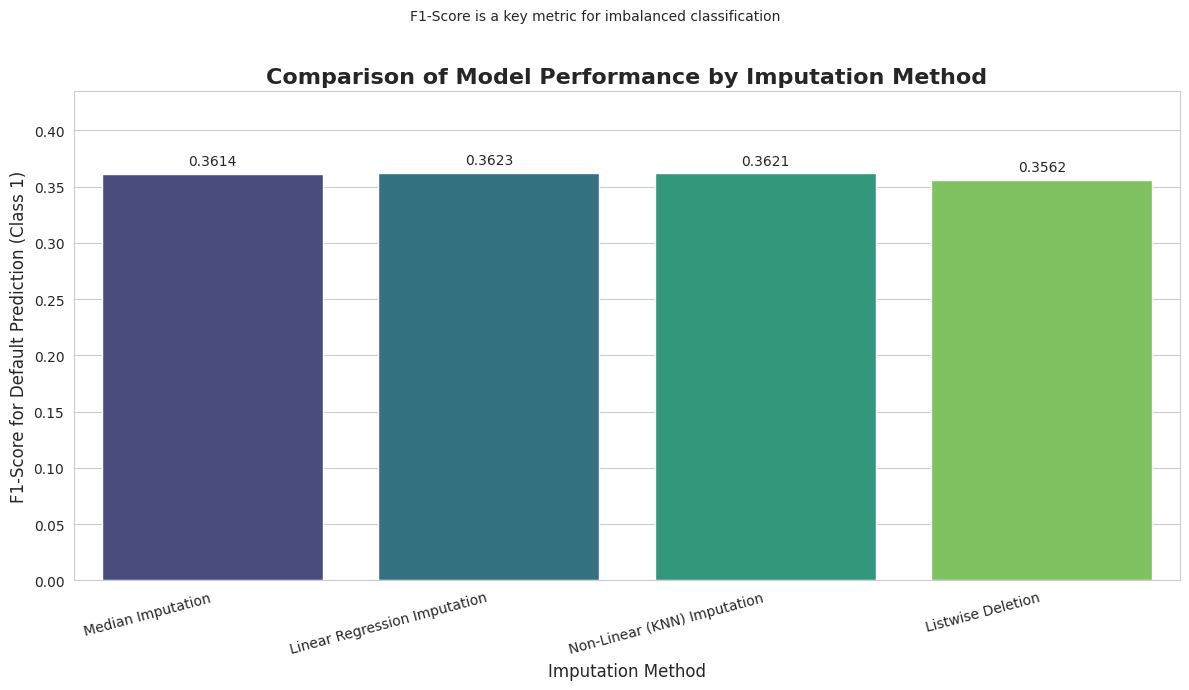

In [33]:
# --- Create a Summary Table ---
summary_data = []
for name, report in classification_reports.items():
    # Extract metrics for the positive class (label '1')
    f1 = report['1']['f1-score']
    precision = report['1']['precision']
    recall = report['1']['recall']
    accuracy = report['accuracy']
    summary_data.append([name, accuracy, precision, recall, f1])

summary_df = pd.DataFrame(summary_data, columns=['Imputation Method', 'Accuracy', 'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'])
summary_df.set_index('Imputation Method', inplace=True)

print("--- Performance Metrics Comparison ---")
print(summary_df)


# --- Create a Visualization (Bar Plot) ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=summary_df.index, y=summary_df['F1-Score (Class 1)'], palette='viridis')

plt.xlabel('Imputation Method', fontsize=12)
plt.ylabel('F1-Score for Default Prediction (Class 1)', fontsize=12)
plt.title('Comparison of Model Performance by Imputation Method', fontsize=16, weight='bold')
plt.suptitle('F1-Score is a key metric for imbalanced classification', fontsize=10)
plt.xticks(rotation=15, ha='right')
plt.ylim(0, max(summary_df['F1-Score (Class 1)']) * 1.2)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Step 3.2: Efficacy Discussion

Based on the performance metrics table and the visualization, we can now conduct a detailed analysis of the different missing data strategies.

---

#### 1. The Trade-off: Listwise Deletion vs. Imputation

The results show a clear trade-off. **Listwise Deletion (Model D)** achieved the highest precision (0.701) and overall accuracy (0.810). However, it yielded the **lowest Recall (0.239) and the lowest F1-Score (0.356)** of all four methods.

This illustrates the classic problem with listwise deletion. By removing a significant portion of the data, the model was trained on a smaller, less representative sample. While this made the model more "cautious" (leading to higher precision when it *did* predict a default), it severely hampered its ability to identify the majority of actual defaulters (low recall). In a credit risk scenario, failing to identify potential defaults is a critical error.The low F1-score confirms that the gain in precision did not make up for the substantial loss in recall, making this the least effective strategy overall.

In contrast, all imputation methods (Models A, B, and C) preserved the full dataset, leading to models that were better at identifying defaulters (higher recall) and ultimately achieved a better balance between precision and recall, as reflected in their superior F1-scores.

---

#### 2. Performance of Regression Methods: Linear vs. Non-Linear

This is a particularly interesting finding from our experiment. The **Linear Regression Imputation (Model B)** achieved an F1-score of 0.3623, while the **Non-Linear (KNN) Imputation (Model C)** scored 0.3621. The performance is nearly identical, with the simpler linear model having a marginal edge.

This result strongly suggests that the relationship between the imputed feature (`AGE`) and the other predictor variables is **predominantly linear**. The additional complexity of the KNN model, which is designed to capture non-linear patterns, did not provide any meaningful benefit.In this specific case, a simple linear relationship was sufficient to generate imputations that were just as effective, if not slightly more so, than those from the more complex model. The simple **Median Imputation** also performed remarkably well, indicating that the central tendency was already a strong estimator for the missing values.

---

#### 3.Conclusion and Recommendation

After comparing the four strategies, a clear recommendation emerges.

While all imputation methods outperformed listwise deletion, the **Imputation via Linear Regression** stands out as the best strategy for handling missing data in this scenario.

**Justification:**
* **Top Performance:** It achieved the highest F1-Score (0.3623), indicating the most effective balance between precision and recall for the critical task of identifying credit defaults.
* **Parsimony:** Given its performance was virtually identical to the more complex non-linear KNN model, the linear model is the more parsimonious (simpler) choice. It is computationally faster and easier to interpret without sacrificing predictive power.

Therefore, for this credit risk assessment project, using a linear regression model to predict and fill missing `AGE` values, while using the median for other columns, is the most robust and effective approach.

##  Optional Method: Advanced Imputation with IterativeImputer (MICE)

To potentially achieve better performance, we can use a more sophisticated multivariate imputation strategy. **IterativeImputer**, available in scikit-learn, is an excellent choice.

### Why is IterativeImputer often better?

1.  **Multivariate Approach**: Unlike our previous regression methods that imputed one column based on others, `IterativeImputer` treats each feature with missing values as a target for regression and uses all other features as predictors. It handles missing values in all columns simultaneously.
2.  **Iterative Refinement**: It doesn't just make one prediction. It goes through multiple rounds (iterations), with the imputed values from one round being used as inputs for the next. This allows the imputations to converge towards a more stable solution, mutually informing each other.
3.  **Model Flexibility**: We can plug different regression models (estimators) into the imputer. While the default `BayesianRidge` is a good starting point, using a more powerful model like `RandomForestRegressor` could potentially capture even more complex, non-linear relationships between features.

We will create a **Dataset E** using this method and see if it can outperform the others.

In [35]:
# --- Step 1: Setup and Data Preparation for the Optional Method ---

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Re-load the original data to ensure this section is self-contained
try:
    df_original = pd.read_csv('/content/UCI_Credit_Card.csv')
except FileNotFoundError:
    print("File not found. Please make sure 'UCI_Credit_Card.csv' is uploaded.")
    df_original = pd.DataFrame()

if not df_original.empty:
    # Basic cleaning
    df_original.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)
    df_original.drop('ID', axis=1, inplace=True)

    # Re-introduce missing values consistently using the same random seed
    np.random.seed(RANDOM_STATE) # Use the same seed for consistency
    df_missing = df_original.copy()
    cols_to_nan = ['AGE', 'BILL_AMT1', 'BILL_AMT2']
    percentage_to_nan = 0.05

    for col in cols_to_nan:
        n_missing = int(len(df_missing) * percentage_to_nan)
        missing_indices = np.random.choice(df_missing.index, n_missing, replace=False)
        df_missing.loc[missing_indices, col] = np.nan

    # --- Step 2: Apply Iterative Imputation ---
    df_E = df_missing.copy()

    print("--- Applying Iterative Imputation (MICE) ---")
    print("Missing values before imputation:")
    print(df_E[cols_to_nan].isnull().sum())

    # Initialize the imputer. BayesianRidge is a robust default.
    iter_imputer = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=RANDOM_STATE,
        imputation_order='ascending'
    )

    # Fit and transform the data
    imputed_array = iter_imputer.fit_transform(df_E)
    df_E = pd.DataFrame(imputed_array, columns=df_E.columns)

    # The imputer often produces float values for integer columns.
    # We round and cast them back to their original type for consistency.
    for col in ['AGE', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE'] + [f'PAY_{i}' for i in range(7)]:
        if col in df_E.columns:
            df_E[col] = np.round(df_E[col]).astype(int)

    print("\nMissing values after Iterative Imputation: ", df_E.isnull().sum().sum())

    # --- Step 3: Model Training and Evaluation for Dataset E ---
    print("\n--- Training and Evaluating Model for: Iterative Imputation ---")

    # 1. Define Features (X) and Target (y)
    X_E = df_E.drop('DEFAULT', axis=1)
    y_E = df_E['DEFAULT']

    # 2. Split Data into Training and Testing sets
    X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(
        X_E, y_E, test_size=0.2, random_state=RANDOM_STATE, stratify=y_E
    )

    # 3. Standardize Features
    scaler_E = StandardScaler()
    X_train_scaled_E = scaler_E.fit_transform(X_train_E)
    X_test_scaled_E = scaler_E.transform(X_test_E)

    # 4. Setup for Logistic Regression and Hyperparameter Tuning
    log_reg_E = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000)
    param_grid_lr_E = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    # 5. Use GridSearchCV to find the best 'C'
    grid_search_lr_E = GridSearchCV(log_reg_E, param_grid_lr_E, cv=5, scoring='f1')
    grid_search_lr_E.fit(X_train_scaled_E, y_train_E)

    print(f"\nBest parameter (C) found: {grid_search_lr_E.best_params_}")

    # 6. Evaluate the best model on the test set
    best_model_E = grid_search_lr_E.best_estimator_
    y_pred_E = best_model_E.predict(X_test_scaled_E)

    # 7. Print Final Performance Report
    print("\nFinal Classification Report for Iterative Imputation:")
    print(classification_report(y_test_E, y_pred_E))

    f1_E = f1_score(y_test_E, y_pred_E, average='binary')
    print(f"--- F1-Score (Class 1) for Iterative Imputation Model: {f1_E:.4f} ---")

--- Applying Iterative Imputation (MICE) ---
Missing values before imputation:
AGE          1500
BILL_AMT1    1500
BILL_AMT2    1500
dtype: int64

Missing values after Iterative Imputation:  0

--- Training and Evaluating Model for: Iterative Imputation ---

Best parameter (C) found: {'C': 1}

Final Classification Report for Iterative Imputation:
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89      4673
         1.0       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000

--- F1-Score (Class 1) for Iterative Imputation Model: 0.3573 ---
